<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
#!pip install matplotlib==3.4.2
#!pip install scikit-learn==1.0
#!pip install --exists-action=i scikit-learn

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [3]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
    

--2021-11-20 09:07:26--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-11-20 09:07:26 (180 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object


In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



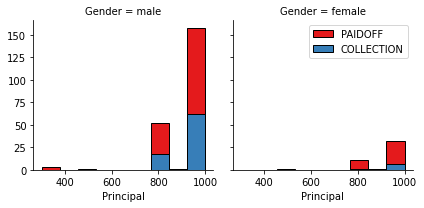

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

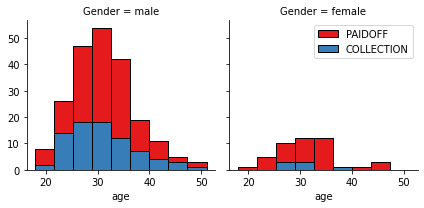

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


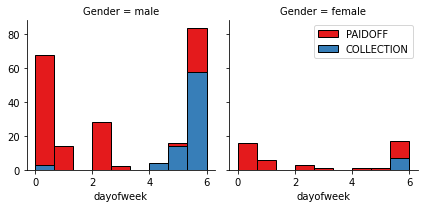

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
print ('Data train set:', X_train.shape,  y_train.shape)
print ('Data test set:', X_test.shape,  y_test.shape)

#selecting the best value of
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_knn = neigh.predict(X_test)
print(yhat_knn[:5])

#train accuracy vs test accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_knn))
print()

Data train set: (259, 8) (259,)
Data test set: (87, 8) (87,)
['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Train set Accuracy:  0.8108108108108109
Test set Accuracy:  0.7816091954022989



# Generating test accuracy for 10 values of k 

In [22]:
Ks = 11
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc


array([0.70114943, 0.62068966, 0.75862069, 0.75862069, 0.7816092 ,
       0.77011494, 0.79310345, 0.77011494, 0.77011494, 0.73563218])

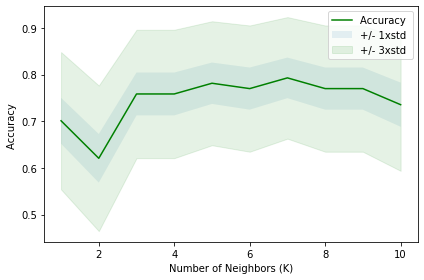

In [23]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print('F1_score:',f1_score(y_test, yhat_knn, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat_knn,pos_label='PAIDOFF'))

F1_score: 0.781609195402299
Jaccard_score: 0.7432432432432432


# Decision Tree


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn import metrics


X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.25, random_state=4)

print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))
print('Shape of X test set {}'.format(X_testset.shape),'&',' Size of Y test set {}'.format(y_testset.shape))

decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
decision_tree.fit(X_trainset,y_trainset)

Shape of X training set (259, 8) &  Size of Y training set (259,)
Shape of X test set (87, 8) &  Size of Y test set (87,)


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [26]:
# predicted tree
pred_tree = decision_tree.predict(X_testset)
print(pred_tree[:10],y_testset[:10])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'] ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


              precision    recall  f1-score   support

  COLLECTION       0.50      0.57      0.53        23
     PAIDOFF       0.84      0.80      0.82        64

    accuracy                           0.74        87
   macro avg       0.67      0.68      0.67        87
weighted avg       0.75      0.74      0.74        87

Confusion matrix, without normalization
[[51 13]
 [10 13]]


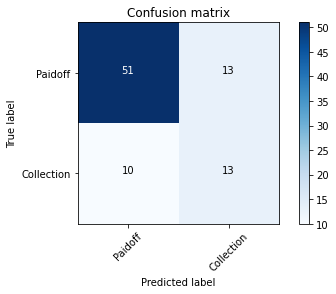

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
decision_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(decision_matrix, classes=['Paidoff','Collection'],normalize= False,  title='Confusion matrix')

In [28]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, pred_tree))
print('F1_score:',f1_score(y_test, yhat, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat,pos_label='PAIDOFF'))

DecisionTrees's Accuracy:  0.7471264367816092
F1_score: 0.735632183908046
Jaccard_score: 0.6891891891891891


# Support Vector Machine


In [29]:
import scipy.optimize as opt
import pylab as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

# train the svm model
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train) 

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


SVC()

In [30]:
yhat = svm_model.predict(X_test)
yhat [:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

              precision    recall  f1-score   support

  COLLECTION       1.00      0.04      0.08        23
     PAIDOFF       0.74      1.00      0.85        64

    accuracy                           0.75        87
   macro avg       0.87      0.52      0.47        87
weighted avg       0.81      0.75      0.65        87

Confusion matrix, without normalization
[[64  0]
 [22  1]]


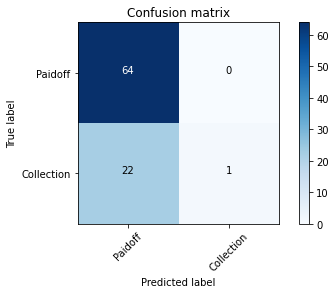

In [31]:
    
# Compute confusion matrix
svm_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(svm_matrix, classes=['Paidoff','Collection'],normalize= False,  title='Confusion matrix')

In [32]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Support vector machine's Accuracy: ", metrics.accuracy_score(y_testset, yhat))
print('F1_score:',f1_score(y_test, yhat, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat,pos_label='PAIDOFF'))

Support vector machine's Accuracy:  0.7471264367816092
F1_score: 0.7471264367816093
Jaccard_score: 0.7441860465116279


# Logistic Regression


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

#split the data 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#train the model
log_reg = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)

#test the model
yhat = log_reg.predict(X_test)
#yhat

yhat_prob = log_reg.predict_proba(X_test)
yhat_prob[:5]

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


array([[0.48, 0.52],
       [0.39, 0.61],
       [0.1 , 0.9 ],
       [0.13, 0.87],
       [0.1 , 0.9 ]])

              precision    recall  f1-score   support

  COLLECTION       0.60      0.13      0.21        23
     PAIDOFF       0.76      0.97      0.85        64

    accuracy                           0.75        87
   macro avg       0.68      0.55      0.53        87
weighted avg       0.71      0.75      0.68        87

Confusion matrix, without normalization
[[62  2]
 [20  3]]


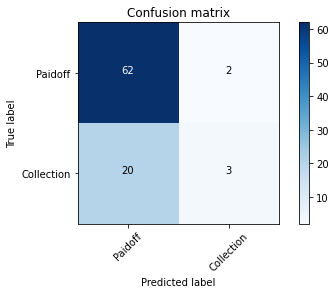

In [34]:
# Compute confusion matrix
log_reg_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(log_reg_matrix, classes=['Paidoff','Collection'],normalize= False,  title='Confusion matrix')

In [35]:
print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_testset, yhat))
print('F1_score:',f1_score(y_test, yhat, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat,pos_label='PAIDOFF'))
print('Log_loss:',log_loss(y_test, yhat_prob))
print()

Logistic Regression's Accuracy:  0.7471264367816092
F1_score: 0.7471264367816093
Jaccard_score: 0.7380952380952381
Log_loss: 0.48848485154845206



# Model Evaluation using Test set


In [36]:
#from sklearn.metrics import jaccard_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import log_loss

First, download and load the test set:


In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-11-20 09:18:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-11-20 09:18:09 (48.1 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [38]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,1


In [39]:
print(test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True))

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64


In [40]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [41]:
set_x = test_df[['Principal','terms','age','Gender','weekend']]
set_x = pd.concat([set_x, pd.get_dummies(test_df['education'])], axis=1)
set_x.drop(['Master or Above'], axis = 1,inplace=True)
set_y = test_df['loan_status'].values
#set_x.head()
#set_y[:5]

In [42]:

# Data Standardization
set_x= preprocessing.StandardScaler().fit(set_x).transform(set_x)
#set_x[:5]

#split data
X_train, X_test, y_train, y_test = train_test_split(set_x, set_y, test_size=0.25, random_state=4)

# knn algorithm.
#selecting the best value of
k = 5
#Train Model and Predict 

neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
#yhat_knn

yhat_knn = neigh.predict(X_test)
print ("Knn's train dataset:", X_train.shape,  y_train.shape)
print ("Knn's test dataset:", X_test.shape,  y_test.shape)

# decision tree algorithms
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6).fit(X_train,y_train)
# predicted tree
yhat_dtree = decision_tree.predict(X_test)
#print(yhat_dtree[:10],y_test[:10])
print ("Decision tree's train dataset:", X_train.shape,  y_train.shape)
print ("Decision tree's test dataset:", X_test.shape,  y_test.shape)

# support vector machine model
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train) 
yhat_svm = svm_model.predict(X_test)
#yhat_svm [:5]
print ("Svm's train dataset:", X_train.shape,  y_train.shape)
print ("Svm's test dataset:", X_test.shape,  y_test.shape)

# logistic regression model
#train the model
log_reg = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
#test the model
yhat_reg = log_reg.predict(X_test)
#yhat probability 
yhat_prob = log_reg.predict_proba(X_test)
#yhat_prob[:5]
print ("Logistic Regression's train dataset:", X_train.shape,  y_train.shape)
print ("Logistic Regression's test dataset:", X_test.shape,  y_test.shape)



Knn's train dataset: (40, 8) (40,)
Knn's test dataset: (14, 8) (14,)
Decision tree's train dataset: (40, 8) (40,)
Decision tree's test dataset: (14, 8) (14,)
Svm's train dataset: (40, 8) (40,)
Svm's test dataset: (14, 8) (14,)
Logistic Regression's train dataset: (40, 8) (40,)
Logistic Regression's test dataset: (14, 8) (14,)


In [43]:
print("K-Nearest Neighbor's Accuracy: ", metrics.accuracy_score(y_test, yhat_knn))
print('F1_score:',f1_score(y_test, yhat_knn, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat_knn,pos_label='PAIDOFF'))

K-Nearest Neighbor's Accuracy:  0.7142857142857143
F1_score: 0.7142857142857143
Jaccard_score: 0.7142857142857143


In [44]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_dtree))
print('F1_score:',f1_score(y_test, yhat_dtree, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat_dtree,pos_label='PAIDOFF'))

DecisionTrees's Accuracy:  0.42857142857142855
F1_score: 0.42857142857142855
Jaccard_score: 0.42857142857142855


In [45]:
print("Support vector machine's Accuracy: ", metrics.accuracy_score(y_test, yhat_svm))
print('F1_score:',f1_score(y_test, yhat_svm, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat_svm,pos_label='PAIDOFF'))

Support vector machine's Accuracy:  0.8571428571428571
F1_score: 0.8571428571428571
Jaccard_score: 0.8571428571428571


In [46]:
print("LogisticRegression's Accuracy: ", metrics.accuracy_score(y_test, yhat_reg))
print('F1_score:',f1_score(y_test, yhat_reg, average='micro')) 
print("Jaccard_score:",jaccard_score(y_test, yhat_reg,pos_label='PAIDOFF'))
print('Log_loss:',log_loss(y_test, yhat_prob))
print()

LogisticRegression's Accuracy:  0.7857142857142857
F1_score: 0.7857142857142857
Jaccard_score: 0.7692307692307693
Log_loss: 0.5294192904505228



# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm            | Jaccard     | F1-score    | LogLoss |
|----------------------|-------------|-------------|---------|
| KNN                  | 0.71428     | 0.71428     | NA      |
| Decision Tree        | 0.42857     | 0.42857     | NA      |
| SVM                  | 0.85714     | 0.85714     | NA      |
| LogisticRegression   | 0.7692      | 0.7857      | 0.52942 |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
|---|---|---|---|
| 2020-10-27 | 2.1 | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27 | 2.0 | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>

<p>
